In [ ]:
!pip install huggingface-hub
!pip install datasets
!pip install nltk

In [2]:
import nltk
import re
from torch.utils.data import DataLoader
from datasets import load_dataset
import datasets
from nltk.corpus import stopwords
from nltk.stem import wordnet
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

In [4]:
dataset = load_dataset('daily_dialog',split='train')

Using custom data configuration default
Reusing dataset daily_dialog (/root/.cache/huggingface/datasets/daily_dialog/default/1.0.0/c03444008e9508b8b76f1f6793742d37d5e5f83364f8d573c2747bff435ea55c)


In [5]:
dataset

Dataset({
    features: ['dialog', 'act', 'emotion'],
    num_rows: 11118
})

In [6]:
df_train = dataset.to_pandas()

In [7]:
df_train['dialog'][0]

array(['Say , Jim , how about going for a few beers after dinner ? ',
       ' You know that is tempting but is really not good for our fitness . ',
       ' What do you mean ? It will help us to relax . ',
       " Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? ",
       " I guess you are right.But what shall we do ? I don't feel like sitting at home . ",
       ' I suggest a walk over to the gym where we can play singsong and meet some of our friends . ',
       " That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . ",
       ' Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . ',
       " Good.Let ' s go now . ", ' All right . '], dtype=object)

In [8]:
stp_w = stopwords.words('english')
def rm_stop_words(tokens):
    clean = []
    for w in tokens:
        if w not in stp_w:
            clean.append(w)
    return clean

In [9]:
def text_normalization(text_list, wo_stop_words = True):
    list_lower = [re.sub(r'[^a-z0-9\s]',' ',text.lower()) for text in text_list] #removes punctuation, converts all letters to lowercase
    tokenized_list = [nltk.word_tokenize(sent) for sent in list_lower]
    if wo_stop_words:
        for i, tokens in enumerate(tokenized_list):
            tokenized_list[i] = rm_stop_words(tokens)
    lema = wordnet.WordNetLemmatizer()
    for i, tokens in enumerate(tokenized_list): 
        tags_list = pos_tag(tokens, tagset = None)
        lema_words = []
        for token, pos_token in tags_list:
            if pos_token.startswith('V'): #verb
                pos_val = 'v'
            elif pos_token.startswith('J'): #adj
                pos_val = 'a'
            elif pos_token.startswith('R'): #adv
                pos_val = 'r'
            else:
                pos_val = 'n' #noun
            lema_token = lema.lemmatize(token, pos_val)
            lema_words.append(lema_token)
        tokenized_list[i] = ' '.join(lema_words)  
    return tokenized_list

In [10]:
text_normalization(df_train['dialog'][0])[0]

'say jim go beer dinner'

Meaning of some sentances lost, especially if we remove "not" adverb. I can fix it later by tuning stop_words parameter in tf-idf (stop_words{‘english’}, list, default=None)

In [11]:
df_train['dialog_norm'] = df_train['dialog'].apply(text_normalization)

In [12]:
df_train['dialog_norm'][0]

['say jim go beer dinner',
 'know tempt really good fitness',
 'mean help u relax',
 'really think make u fat act silly remember last time',
 'guess right shall feel like sit home',
 'suggest walk gym play singsong meet friend',
 'good idea hear mary sally often go play pingpong perhaps make foursome',
 'sound great willing could ask go dance u excellent exercise fun',
 'good let go',
 'right']

In [16]:
df_train.columns

Index(['dialog', 'act', 'emotion', 'dialog_norm'], dtype='object')

### Creating dataframe for utterances

In [17]:
def get_sent_ids(dialog):
    global dialog_ind
    num_sent = len(dialog)
    sent_ids = list(zip(dialog, np.full(num_sent,dialog_ind), np.arange(num_sent)))
    dialog_ind +=1
    return sent_ids

In [18]:
#get_sent_ids(0,df_train['dialog_norm'][0])
dialog_ind = 0
s_id = df_train['dialog_norm'].apply(lambda x: get_sent_ids(x))

In [19]:
utter_df = pd.DataFrame(pd.Series.sum(s_id), columns = ['utters', 'dialog_id', 'utter_in_dialog'])

In [20]:
utter_df

utters  ...  utter_in_dialog
0                                 say jim go beer dinner  ...                0
1                         know tempt really good fitness  ...                1
2                                      mean help u relax  ...                2
3      really think make u fat act silly remember las...  ...                3
4                   guess right shall feel like sit home  ...                4
...                                                  ...  ...              ...
87165                                    want pair locus  ...                1
87166                       take look one display please  ...                2
87167                                       need size 41  ...                3
87168                                 could check please  ...                0
87169                                        okay minute  ...                1

[87170 rows x 3 columns]

In [21]:
tfidf = TfidfVectorizer()

In [22]:
tf_idf_transformed = tfidf.fit_transform(utter_df['utters']).toarray()

In [23]:
print(tfidf.get_feature_names()[:20])

['00', '000', '007', '0085', '01', '010', '01088256798', '011', '01563', '01705', '0234', '04', '05', '050920', '053', '060', '075', '08', '09', '099']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Visual explorations

In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(tf_idf_transformed)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


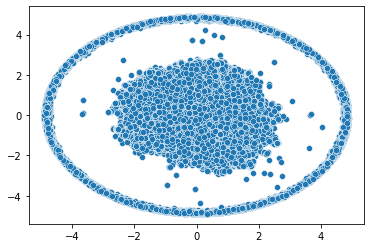

In [26]:
sns.scatterplot(tsne_results[:,0],tsne_results[:,1])

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
tsne_results.dump('./data/tsne_results.dat')

In [30]:
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
pca = PCA(n_components=3)

In [ ]:
pca_result = pca.fit_transform(tf_idf_transformed)

In [ ]:
pca_result.dump('./data/pca_result.dat')

In [31]:
pca_result = np.load('./data/pca_result.dat', allow_pickle=True)

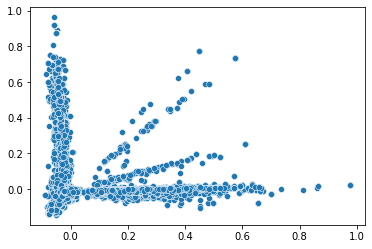

In [33]:
sns.scatterplot(
    x=pca_result[:,0], y=pca_result[:,1]
)

In [32]:
fig = px.scatter_3d(
    pca_result, x=0, y=1, z=2,
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [36]:
fig.write_html('./data/daily-dialog-train-pca.html')

Should I remove numbers from the text? \
Responce is NO


In [37]:
from sklearn.cluster import KMeans

In [ ]:
ssd = [] # Sum of squared distances
n_clust = [4,5,6,7,8,9,10]
for clust in n_clust:
    km = KMeans(clust)
    km.fit(tf_idf_transformed)
    with open('ssd.txt', 'a') as out_f:
        out_f.write(str(km.inertia_)+'\n')
    ssd.append(km.inertia_)

In [ ]:
print(ssd)

In [ ]:
 np.arange(10,500, 20)

array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250,
       270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490])